In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
import shutil

plt.ion()   # interactive mode

In [39]:
# Unpack val folder
val_labels, val_path = [], "tiny-imagenet-5/val"

with open(file=os.path.join(val_path, 'val_annotations.txt')) as f:
    val_labels = f.readlines()

val_labels = [tuple(item.strip("\n").split("\t")[:2]) for item in val_labels]

# item[0] is imagePath and item[1] is class folder
for item in val_labels:
    img_path = os.path.join(val_path, "images", item[0])
    if not os.path.isdir(os.path.join(val_path, item[1])):
        os.mkdir(os.path.join(val_path, item[1]))
        
    os.popen('cp {} {}'.format(img_path, os.path.join(val_path, item[1], item[0])))   

shutil.rmtree(os.path.join(val_path, "images"))

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'tiny-imagenet-5'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
image_datasets['train'].classes

['n09193705', 'n09246464', 'n09256479', 'n09332890', 'n09428293']

# Fixed Feature Extractor

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# Load pre-trained model and reset final fully connected layer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5312 Acc: 0.4040
val Loss: 1.1511 Acc: 0.5600

Epoch 1/49
----------
train Loss: 1.4283 Acc: 0.4704
val Loss: 0.9482 Acc: 0.6640

Epoch 2/49
----------
train Loss: 1.3519 Acc: 0.5052
val Loss: 0.7964 Acc: 0.7120

Epoch 3/49
----------
train Loss: 1.2051 Acc: 0.5336
val Loss: 0.7112 Acc: 0.7400

Epoch 4/49
----------
train Loss: 1.1826 Acc: 0.5540
val Loss: 0.7965 Acc: 0.7040

Epoch 5/49
----------
train Loss: 1.1247 Acc: 0.5716
val Loss: 0.7155 Acc: 0.7440

Epoch 6/49
----------
train Loss: 1.0782 Acc: 0.5936
val Loss: 0.9047 Acc: 0.6720

Epoch 7/49
----------
train Loss: 0.8717 Acc: 0.6672
val Loss: 0.5929 Acc: 0.8040

Epoch 8/49
----------
train Loss: 0.8741 Acc: 0.6676
val Loss: 0.5955 Acc: 0.7920

Epoch 9/49
----------
train Loss: 0.8120 Acc: 0.6928
val Loss: 0.5767 Acc: 0.7720

Epoch 10/49
----------
train Loss: 0.8423 Acc: 0.6784
val Loss: 0.5791 Acc: 0.7920

Epoch 11/49
----------
train Loss: 0.8141 Acc: 0.6976
val Loss: 0.5897 Acc: 0.7880

Ep

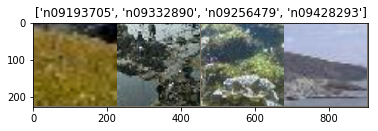

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

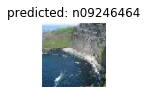

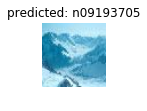

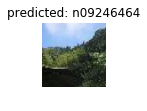

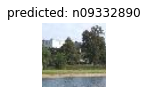

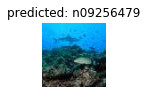

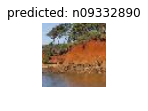

In [11]:
visualize_model(model_ft)

In [15]:
torch.save(model_ft.state_dict(), "model_ft")

# CNN Image Classifier

In [6]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/49
----------
train Loss: 1.4351 Acc: 0.4140
val Loss: 0.9683 Acc: 0.6160

Epoch 1/49
----------
train Loss: 1.3917 Acc: 0.4792
val Loss: 0.9073 Acc: 0.6440

Epoch 2/49
----------
train Loss: 1.4415 Acc: 0.4776
val Loss: 0.9229 Acc: 0.6520

Epoch 3/49
----------
train Loss: 1.3738 Acc: 0.4844
val Loss: 1.0125 Acc: 0.5720

Epoch 4/49
----------
train Loss: 1.4009 Acc: 0.4856
val Loss: 0.9238 Acc: 0.6560

Epoch 5/49
----------
train Loss: 1.3417 Acc: 0.5112
val Loss: 1.0729 Acc: 0.5920

Epoch 6/49
----------
train Loss: 1.3181 Acc: 0.5088
val Loss: 0.7992 Acc: 0.6960

Epoch 7/49
----------
train Loss: 1.1306 Acc: 0.5560
val Loss: 0.9500 Acc: 0.6240

Epoch 8/49
----------
train Loss: 1.1616 Acc: 0.5400
val Loss: 0.8371 Acc: 0.6600

Epoch 9/49
----------
train Loss: 1.1262 Acc: 0.5644
val Loss: 0.7784 Acc: 0.6880

Epoch 10/49
----------
train Loss: 1.1396 Acc: 0.5584
val Loss: 0.7913 Acc: 0.6800

Epoch 11/49
----------
train Loss: 1.1106 Acc: 0.5536
val Loss: 0.7688 Acc: 0.6920

Ep

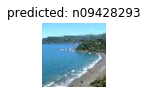

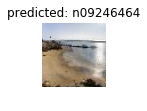

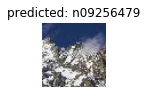

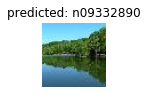

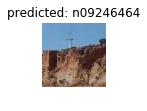

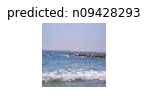

In [7]:
model_cnn = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

visualize_model(model_cnn)

plt.ioff()
plt.show()

In [8]:
torch.save(model_cnn.state_dict(), "model_cnn")